In [1]:
#----------------------------
# import libraries
#----------------------------
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def create_input_x(x_raw, K):
    size = len(x_raw)
    x_out = np.zeros(shape=(size,K))
    for N in range(K, size):
        for i in range(K):
            x_out[N][i] = x_raw[N-i-1]
    return x_out

In [3]:
def reserve_test_set(data, N):
    size = len(data)
    test_set = x[(size-N):size]
    data = data[:-365]
    return data, test_set

In [4]:
def temporal_kfold(x, y, K, folds):
    x = np.array_split(x, folds)
    y = np.array_split(y, folds)
    # start fold_0 array
    fold_x = [x[0]]
    fold_y = [y[0]]
    # remove first K data from first fold
    fold_x[0] = fold_x[0][K:]
    fold_y[0] = fold_y[0][K:]
    # start validation array
    val_x = [x[1]]
    val_y = [y[1]]
    for i in range(1, folds - 1):
        #fold_x[i] = fold_x[i-1] concat x[i]
        fold_x.append( np.concatenate((fold_x[i-1], x[i]), axis=0) )
        fold_y.append( np.concatenate((fold_y[i-1], y[i]), axis=0) )
        # validation array
        val_x.append( x[i+1] )
        val_y.append( y[i+1] )
    return fold_x, fold_y, val_x, val_y

In [5]:
def pseudoinverse(y, phi, alpha):
    # identity matrix (with first element = 0) used for rigde regression
    I = np.identity(phi.shape[1])
    I[0][0] = 0
    w = np.linalg.inv( (phi.T @ phi) + (alpha * I) ) @ phi.T @ y
    #w = np.linalg.inv( phi.T @ phi) @ phi.T @ y
    return w

In [6]:
def calc_error(x, y, w):
    phi = np.insert(x, 0, [1], axis=1)
    ŷ = phi @ w
    e = y - ŷ
    rmse = np.sqrt( np.mean(e*e) )
    return rmse

In [7]:
def train(x, y, K, F, alpha):
    if (F == 1):
        phi = np.insert(x, 0, [1], axis=1)
        w = pseudoinverse(y, phi, alpha)
        error = calc_error(x, y, w)
    else:
        # k-fold cross-validation
        fold_x, fold_y, val_x, val_y = temporal_kfold(x, y, K, F)
        # training the model
        error = np.zeros(shape=(F-1, 1))
        w = np.zeros(shape=(K, 1))
        # calculate w and error for each fold
        for j in range(F-1):
            phi = np.insert(fold_x[j], 0, [1], axis=1)
            w = pseudoinverse(fold_y[j], phi, alpha)
            error[j] = calc_error(val_x[j], val_y[j], w)
    error_mean = np.mean(error)
    return w, error_mean

In [8]:
def linear_transformation(x, lo, hi):
    # lo = lower limit desired
    # hi = higher limit desired
    # y = a * x + b
    max_x = np.max(x)
    min_x = np.min(x)
    # hi = a * max_x + b
    # lo = a * min_x + b
    a = (hi - lo) / (max_x - min_x)
    b = hi - (a * max_x)
    return a, b

In [9]:
def feature_scaling(x, a, b):
    y = a * x + b
    return y

In [10]:
def undo_scaling(y, a, b):
    x = (y - b) / a
    return x

In [11]:
def transform_features(x, wk):
    xt = (wk @ x.T).T
    xt = np.tanh(xt)
    return xt

In [12]:
# #Je(x, y, K, folds, alpha=M)[1]
# def sqr(x, y, K, folds, alpha):
#     y = alpha**2 - alpha - 1
#     return 0, y*y

In [13]:
def find_alpha(x, y, K, folds, a, b, d, Je):
    # a and b: initial interval of uncertainty
    # d: desired final interval size
    # gr: golden ratio = (np.sqrt(5) - 1)/2
    # L (lambda): midpoint used by the algorithm
    # M (mi): midpoint used by the algorithm
    gr = 0.618
    L = a + (1 - gr)*(b - a)
    M = a + gr*(b - a)
    J_lambda = Je(x, y, K, folds, alpha=L)[1]
    J_mi = Je(x, y, K, folds, alpha=M)[1]
    while ( (abs(a-b)/2) >= d ):
        if (J_lambda > J_mi):
            a = L
            L = M
            M = a + gr*(b - a)
            J_lambda = J_mi
            J_mi = Je(x, y, K, folds, alpha=M)[1]
        else:
            b = M
            M = L
            L = a + (1 - gr)*(b - a)
            J_mi = J_lambda
            J_lambda = Je(x, y, K, folds, alpha=L)[1]
    alpha = (a + b)/2
    return alpha

In [14]:
# def find_alpha_for_one_T(x, y, K, folds, T, Je=train):
#     # test 1: calculate alpha for ONE value of T
#     wk = np.random.rand(T, K)
#     xt = transform_features(x, wk)
#     alpha = find_alpha(xt, y, K, folds, a=1e-10, b=1e3, d=1e-15, Je=train)
#     return alpha

In [15]:
def regularization(x, y, K, features, folds, a, b, d):
    w = features * [0]
    wk = features * [0]
    e = features * [0]
    alpha = features * [0]
    for T in range(1, features + 1):
        # map x --> xt
        wk[T-1] = np.random.rand(T, K)
        xt = transform_features(x, wk[T-1])
        #------------------------------------------------------
        # find best alpha in interval [a, b] with precision d
        print('T =', T)
        print('sweeping alpha to find the best value...')
        alpha[T-1] = find_alpha(xt, y, K, folds, a, b, d, train)
        #print('alpha[', T, '] = ', alpha[T-1], '\n', sep='')
        print('alpha[', T, '] = ', alpha[T-1], sep='')
        #------------------------------------------------------
        w[T-1], e[T-1] = train(xt, y, K, folds, alpha[T-1])
        print('error = ', e[T-1], '\n')
    return w, e, alpha, wk

In [16]:
#-----------------------------
# manipulating data
#-----------------------------
# read csv file
df = pd.read_csv('daily-minimum-temperatures.csv')
date = df['Date'].values
temp = df['Temp'].values
size = len(date)
#------------------
limits = [-1, 1]
a, b = linear_transformation(temp, limits[0], limits[1])
temp2 = feature_scaling(temp, a, b)
#------------------
# path to save figures
path = 'Figures/figures ex2/'

In [17]:
#-----------------------------
# prepare data and reserve test set
#-----------------------------
# input data
x_raw = temp2[:-365]
y = np.array([temp2]).T
y = y[:-365]
# reserve test set
ts = temp2[-365:]

In [18]:
#-----------------------------
# train model for T = [0,100]
#-----------------------------
T = 100
K = 5
folds = 9
x = create_input_x(x_raw, K)
a = 1e-10
b = 1e3
d = 1e-12
w, e, alpha, wk = regularization(x, y, K, T, folds, a, b, d)
# undo scaling for error
max_temp = np.max(temp)
min_temp = np.min(temp)
e = np.asarray(e) / 2 * (max_temp - min_temp)

T = 1
sweeping alpha to find the best value...
alpha[1] = 5.460179024104362
error =  0.21705517542288152 

T = 2
sweeping alpha to find the best value...
alpha[2] = 1.0072807510469382e-10
error =  0.20905472156980565 

T = 3
sweeping alpha to find the best value...
alpha[3] = 1.0072807510469382e-10
error =  0.21673565179836723 

T = 4
sweeping alpha to find the best value...
alpha[4] = 1.0072807510469382e-10
error =  0.20068449501806496 

T = 5
sweeping alpha to find the best value...
alpha[5] = 0.004024640544741758
error =  0.19862069884919978 

T = 6
sweeping alpha to find the best value...
alpha[6] = 0.013297951774261397
error =  0.19868076722278094 

T = 7
sweeping alpha to find the best value...
alpha[7] = 0.025760156484918407
error =  0.19122840236662267 

T = 8
sweeping alpha to find the best value...
alpha[8] = 0.03567586033510413
error =  0.19097098378295335 

T = 9
sweeping alpha to find the best value...
alpha[9] = 0.0479773377144566
error =  0.19216641004703633 

T = 10
swe

alpha[75] = 0.25890890633849706
error =  0.19065771132697817 

T = 76
sweeping alpha to find the best value...
alpha[76] = 0.396062904411874
error =  0.19058395642789364 

T = 77
sweeping alpha to find the best value...
alpha[77] = 0.2829736845224157
error =  0.19057242047203418 

T = 78
sweeping alpha to find the best value...
alpha[78] = 0.33492867049322084
error =  0.19069113153753015 

T = 79
sweeping alpha to find the best value...
alpha[79] = 0.4821655275665086
error =  0.1904993900105123 

T = 80
sweeping alpha to find the best value...
alpha[80] = 0.18166609882581555
error =  0.19076321882001962 

T = 81
sweeping alpha to find the best value...
alpha[81] = 0.30413902856007247
error =  0.19068652400328018 

T = 82
sweeping alpha to find the best value...
alpha[82] = 0.48090262944259143
error =  0.1903597602291427 

T = 83
sweeping alpha to find the best value...
alpha[83] = 0.4923005753073239
error =  0.1907195491458223 

T = 84
sweeping alpha to find the best value...
alpha[84]

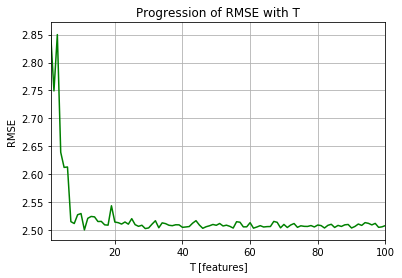

In [19]:
# plots
plt.plot(range(1,T+1), e, 'g')
# axis label
plt.xlabel('T [features]')
plt.ylabel('RMSE')
# axis adjust
plt.autoscale(axis='x', tight=True)
# title
plt.title('Progression of RMSE with T')
# add grid
plt.grid(True)
plt.savefig(path + 'figure 1 - progression of rmse with T', dpi=300)
plt.show()

In [27]:
# reserve variables related to the T with minimum error
T_best = np.argmin(e)
alpha_best = alpha[T_best]
wk_best = wk[T_best]
w_best = w[T_best]
print('T for minimun error = ' + str(T_best))

T for minimun error = 10


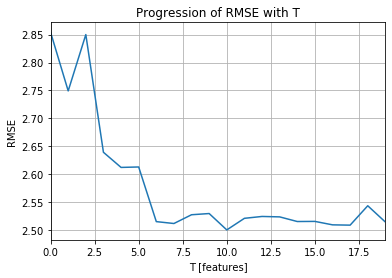

In [28]:
# plots
plt.plot(range(max(0,T_best-10),min(T,T_best+10)), e[max(0,T_best-10):min(T,T_best+10)])
# axis label
plt.xlabel('T [features]')
plt.ylabel('RMSE')
# axis adjust
plt.autoscale(axis='x', tight=True)
# title
plt.title('Progression of RMSE with T')
# add grid
plt.grid(True)
plt.savefig(path + 'figure 2 - progression of rmse with T (zoomed)', dpi=300)
plt.show()

In [29]:
# test set (x)
ts_x = create_input_x(temp2, K)[-365:]
ts_xt = transform_features(ts_x, wk_best)
# test set (y)
y = np.array([temp]).T
ts_y = y[-365:]

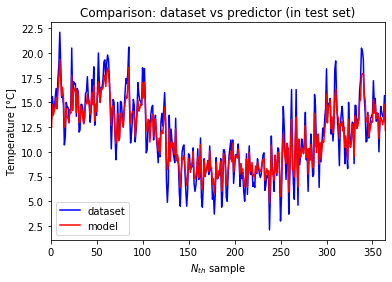

In [30]:
a, b = linear_transformation(temp, limits[0], limits[1])
phi = np.insert(ts_xt, 0, [1], axis=1)
ŷ = phi @ w_best
ŷ = undo_scaling(ŷ, a, b)
ts = temp[-365:]
# plots
plt.plot(ts,'b', label='dataset')
#plt.plot(ŷ,'r', label='model')
plt.plot(np.roll(ŷ,-1),'r', label='model')
# axis label
plt.xlabel(r'$N_{th}$ sample')
plt.ylabel('Temperature [°C]')
# title
plt.title('Comparison: dataset vs predictor (in test set)')
plt.autoscale(axis='x', tight=True)
plt.legend()
plt.savefig(path + 'figure 3 - dataset vs predictor.png', dpi=300)
plt.show()

In [34]:
#e = ts_y - ŷ
e = ts_y - np.roll(ŷ,-1)
# undo scaling for error
max_temp = np.max(temp)
min_temp = np.min(temp)
e = np.asarray(e) / 2 * (max_temp - min_temp)
e = np.mean(e)
print('RMSE = ' + str(e))

RMSE = 1.3289615195099134
